<a href="https://colab.research.google.com/github/Bepo2002/Humbug-4YP/blob/main/Test_bench_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mosquito Virtual Test Bench V1.2

In [ ]:
import zipfile
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
from scipy.stats.mstats import winsorize

# Helper Functions

In [ ]:
# Finds specific sound in zip and extracts it
def extract_sound(filename):
  zip_files = ['./drive/MyDrive/4YP/train.zip','./drive/MyDrive/4YP/dev.zip']
  folders = ['train/', 'dev/a/', 'dev/b/']
  dest_dir = './drive/MyDrive/4YP/Data'
  filename_to_extract = str(filename) + '.wav'

  for zip_path in zip_files:
    for folder in folders:
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        filename_to_extract = folder + filename_to_extract
        if filename_to_extract in zip_ref.namelist():
          zip_ref.extract(filename_to_extract, dest_dir)
          print(f"{filename_to_extract} has been extracted to {dest_dir}")
          final = './drive/MyDrive/4YP/Data/'+ filename_to_extract
          return wavfile.read(final)
  print(f"{filename_to_extract} not found in any of the provided ZIP files.")

# Read in .csv
def csv_read():
  metadata = pd.read_csv('./drive/MyDrive/4YP/Data/humbugdb_zenodo_edited.csv')
  metadata = metadata.set_index('id')
  return metadata

def gaussian(x, mu, sigma):
  return np.exp(-((x - mu)**2) / (2 * sigma**2))

## Mosquito Mixer (see Audio_mix_test)

In [ ]:
# Full function for generating noise + mosquito
def long_sound_gen(mos_num,noise_factor=1):
  metadata = csv_read()

  # Choose a long noise sound
  subset = metadata[metadata['sound_type'] == 'background']
  subset = subset.loc[metadata['length'] > 10]
  subset = subset.loc[metadata['sample_rate'] == 44100]
  subset = subset.loc[metadata['clean'] == "Y"]
  sel_noise = subset.sample()
  noise_id = sel_noise.index.values[0]

  # Extract the sound wave and find samplerate
  n_samplerate, noise = extract_sound(noise_id)

  # Choose a shorter mosquito sound
  subset = metadata[metadata['sound_type'] == 'mosquito']
  subset = subset.loc[(metadata['length'] < 10) & (metadata['length'] > 1)]
  subset = subset.loc[metadata['sample_rate'] == 44100]
  sel_mos = subset.sample()
  mos_id = sel_mos.index.values[0]

  # Import the sound wave and find samplerate
  samplerate, data = extract_sound(mos_id)


  # Add sound to random time in noise
  # Initilise vectors to store new audio and whether each sample is from mosquito or noise
  new_audio = np.zeros(noise.size)
  sound_cat = np.zeros(noise.size)
  old_audio = np.zeros(noise.size)

  for i in range(0,mos_num):

    # Choose a 'time' to put the middle of mosquito sound wave
    mosquito_time = np.random.randint(data.size//2, high=noise.size-data.size//2, dtype=int)
    print("Adding mosquito noise at " + str(round(mosquito_time/samplerate,3)) + "s")

    # Put wave into long array
    new_audio[mosquito_time - data.size//2:(mosquito_time - data.size//2)+data.size] = data
    sound_cat[mosquito_time - data.size//2:mosquito_time + data.size//2] = 1

    # Generate gaussian in same place as mos audio
    x = np.linspace(0,noise.size,noise.size,dtype=int)
    y = gaussian(x,mosquito_time,data.size/6)

    # Multiply to apply gaussian to audio
    old_audio = y*new_audio + old_audio

  # Add faded mosquito sound to background noise
  full_audio = noise*noise_factor + old_audio

  return full_audio, samplerate, sound_cat

## Audio chopper

In [ ]:
# Function for chopping up audio and forming matrix (each row is a clip, each column a sample)
def chop_chop(audio,samplerate,seconds_per_clip=1):
  # Choose bin size (default 1 second clip)
  bin_size = int(samplerate*seconds_per_clip)

  # Reshape Data
  rows = int(audio.size/bin_size)
  audio = audio[:rows*bin_size]
  audio = np.reshape(audio,(rows,bin_size))
  audio = np.concatenate((audio,np.zeros((rows,1))),axis=1)
  return audio

## Binarizer

In [ ]:
def binarize(input_array,thresh = 0):
  for i in range(len(input_array)):
    if input_array[i] > thresh:
      input_array[i] = 1
    else:
      input_array[i] = 0

  return input_array

## MFCC Generation

In [ ]:
# Function to generate MFCCs for one long mixed audio
def generate_training_data(mosquitoness=2, noise_factor=0.5, chop_size=1, n_mfcc=10):
  # Create the long mixed audio (mosquito + noise)
  full_audio, samplerate, sound_cat = long_sound_gen(mosquitoness,noise_factor)

  # audio_normal = winsorize(full_audio)

  # Chop audio into X second clips
  chopped_audio = chop_chop(full_audio,samplerate,chop_size)

  # Create an average 'mosquitoness' of each clip
  chopped_cat = chop_chop(sound_cat,samplerate,chop_size)
  av_chopped_cat = np.mean(chopped_cat,axis=1)

  # Generate MFCCs for each 1s clip (squeeze as librosa function generates in 2D for some reason)
  mfccs = np.zeros((len(chopped_audio),n_mfcc))
  for i in range(0,len(chopped_audio)):
    test_var = np.squeeze(librosa.feature.mfcc(y=chopped_audio[i].astype(float),
                                               sr=samplerate, n_mfcc = n_mfcc,
                                               hop_length = len(chopped_audio[i])*2))
    mfccs[i] = test_var

  # Returns a number of seconds in audio x n_mfcc matrix and an array of sound category (how much mosquito) in each X second chop
  return mfccs, av_chopped_cat

In [ ]:
# Generates training data for several long audio segments
def multiple_training_data(amount_of_audio, mosquitoness=2, noise_factor=0.5,
                           chop_size=1, n_mfcc=10):
  X, Y = generate_training_data(mosquitoness, noise_factor, chop_size, n_mfcc)
  for i in range(0,amount_of_audio-1):
    mfccs, av_chopped_cat = generate_training_data()
    X = np.concatenate((X,mfccs))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

def multiple_training_random_noise(amount_of_audio, mosquitoness=2,
                                   chop_size=1, n_mfcc=10):
  X, Y = generate_training_data(mosquitoness,
                                noise_factor=np.random.uniform(low=0.1,
                                                               high=0.5))
  for i in range(0,amount_of_audio-1):
    mfccs, av_chopped_cat = generate_training_data(mosquitoness,
                                                   noise_factor=np.random.uniform(low=0.1,
                                                                                  high=0.5))
    X = np.concatenate((X,mfccs))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

# Working Code

In [ ]:
np.random.seed(0)
coef, cats = multiple_training_random_noise(50,mosquitoness=3)

print("MFCC Matrix shape:" + str(coef.shape))
print("Mosquitoness Matrix shape:" + str(cats.shape))

train/734.wav has been extracted to ./drive/MyDrive/4YP/Data
train/220997.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 6.388s
Adding mosquito noise at 2.272s
Adding mosquito noise at 8.801s
train/1564.wav has been extracted to ./drive/MyDrive/4YP/Data
train/3498.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 7.249s
Adding mosquito noise at 5.815s
Adding mosquito noise at 8.319s
train/1352.wav has been extracted to ./drive/MyDrive/4YP/Data
train/2793.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 15.158s
Adding mosquito noise at 6.769s
Adding mosquito noise at 14.702s
train/1564.wav has been extracted to ./drive/MyDrive/4YP/Data
train/221506.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 8.281s
Adding mosquito noise at 3.808s
Adding mosquito noise at 6.811s
train/1352.wav has been extracted to ./drive/MyDrive/4YP/Data
train/221220.wav has been extracted to ./drive/MyDriv

## Split into training and dev

In [ ]:
from sklearn.model_selection import train_test_split

num_mos = np.count_nonzero(cats)
num_back = len(cats) - num_mos

print("Mosquito clips: " + str(num_mos))
print("Background clips: "  + str(num_back))

all = np.concatenate((coef,cats.reshape(-1, 1)), axis=1)

condition = all[:, 10] > 0
mos = all[condition]
back = all[~condition]

Mosquito clips: 532
Background clips: 318


In [ ]:
#X_train, X_dev, y_train, y_dev = train_test_split(coef, cats, test_size=0.2, random_state=42)
mos1, mos2 = train_test_split(mos, test_size=0.5, random_state=42)
back1, back2 = train_test_split(back, test_size=1-(mos1.shape[0]/back.shape[0]),
                                random_state=42)

rng = np.random.default_rng()

train = np.vstack([mos1,back1])
dev = np.vstack([mos2,back2])

rng.shuffle(train, axis=0)
rng.shuffle(dev, axis=0)

X_train = train[:, 0:10]
y_train = train[:, 10]
X_dev = dev[:, 0:10]
y_dev = dev[:, 10]

num_mos_train = np.count_nonzero(y_train)
num_back_train = len(y_train) - num_mos_train
num_mos_dev = np.count_nonzero(y_dev)
num_back_dev = len(y_dev) - num_mos_dev

print("num_mos_train: " + str(num_mos_train))
print("num_back_train: " + str(num_back_train))
print("num_mos_dev: " + str(num_mos_dev))
print("num_back_dev: " + str(num_back_dev))

num_mos_train: 266
num_back_train: 266
num_mos_dev: 266
num_back_dev: 52


## Test out K-nearest neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_b = binarize(y_train)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train_b)
y_pred = neigh.predict(X_dev)

In [ ]:
y_pred_b = binarize(y_pred)
y_dev_b = binarize(y_dev)

True positive: 117
True negative: 48
False positive: 4
False negative: 149
Sensitivity: 0.4398496240601504
Specificity: 0.9230769230769231
Score: 1.8461538461538463


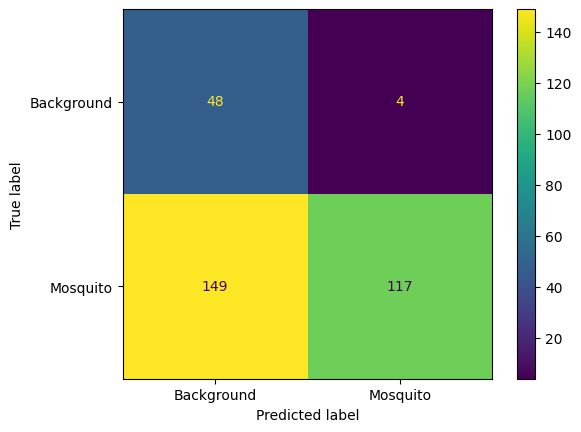

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion = confusion_matrix(y_dev_b, y_pred_b)
true_pos = confusion[1][1]
true_neg = confusion[0][0]
false_pos = confusion[0][1]
false_neg = confusion[1][0]

print("True positive: " + str(true_pos))
print("True negative: " + str(true_neg))
print("False positive: " + str(false_pos))
print("False negative: " + str(false_neg))

sensitivity = true_pos/(true_pos+false_neg)
specificity = true_neg/(true_neg+false_pos)

print("Sensitivity: " + str(sensitivity))
print("Specificity: " + str(specificity))
print("Score: " + str(specificity+specificity))
disp = ConfusionMatrixDisplay(confusion, display_labels = ["Background", "Mosquito"])
disp.plot()
plt.show()